In [32]:
import numpy as np
import pandas as pd
from radardetseval.conversions.objects_into_polyline import object_into_polyline
from AptivDataExtractors.utilities.MathFunctions import calc_velocity_in_position, calc_position_in_bounding_box, pol2cart, rot_2d_sae_cs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

from radardetseval.association.nearest_det_to_object import find_nearest_det_on_object
from radardetseval.configs.default_radar import DefaultRadar
from radardetseval.configs.defaut_reference import DefaultReference
from radardetseval.conversions.objects_into_polyline import get_object_pos_vel_cov
from radardetseval.simulators.DetFromRadarObjectSim import DetFromRadarObjectSim
from radardetseval.simulators.RadarObjectSim import RadarObjectSim
from radardetseval.stats.nees import nees_value
from radardetseval.visualization.plot_polyline import plot_polyline, plot_polyline_range_rates
from radardetseval.visualization.plot_sensor import plot_sensor
from radardetseval.visualization.plot_object import plot_object
from radardetseval.visualization.plot_detection import plot_detection_scs
from radardetseval.unc_prop.pos_vel_cart_to_polar import unc_prop_pos_rel_vel_cart_to_polar
from radardetseval.visualization.utilities import publish_reduced_labels
from radardetseval.utilities.cart_state_to_polar_state import cart_state_to_polar_state

In [33]:
def plot_object_wrapper(ax, rt_object, **kwargs):
    plot_object(ax, None, rt_object.position_x, rt_object.position_y, 
                rt_object.velocity_otg_x, rt_object.velocity_otg_y, 
                rt_object.center_x, rt_object.center_y, 
                rt_object.bounding_box_dimensions_x, rt_object.bounding_box_dimensions_y, 
                rt_object.bounding_box_orientation, velocity_scale=1.0, **kwargs)
    
def plot_detection_wrapper(ax, det, **kwargs):
    plot_detection_scs(ax, det.det_range, det.det_range_rate, det.det_azimuth, **kwargs)
    
def get_range_rate_profile(rt_object, n_grid=101):
    x_ref_mesh, y_ref_mesh = np.meshgrid(np.linspace(0,1,n_grid), np.linspace(0,1,n_grid))
    pos_x, pos_y = calc_position_in_bounding_box(rt_object.position_x, rt_object.position_y,
                                                 rt_object.bounding_box_dimensions_x,
                                                 rt_object.bounding_box_dimensions_y,
                                                 rt_object.bounding_box_orientation,
                                                 rt_object.bounding_box_refpoint_long_offset_ratio,
                                                 rt_object.bounding_box_refpoint_lat_offset_ratio,
                                                 x_ref_mesh, y_ref_mesh)
    vel_x, vel_y = calc_velocity_in_position(rt_object.position_x, rt_object.position_y,
                                             rt_object.velocity_otg_x, rt_object.velocity_otg_y,
                                             rt_object.yaw_rate,
                                             pos_x, pos_y)
    _, _, range_rate, _ = cart_state_to_polar_state(pos_x, pos_y, vel_x, vel_y)
    return pos_x, pos_y, range_rate


def is_point_in_bb(point_x: np.array, point_y: np.array,
                   bb_center_x: np.array, bb_center_y: np.array,
                   bb_length: np.array, bb_width: np.array, bb_orientation: np.array):
    bb_length_half = bb_length / 2.0
    bb_width_half = bb_width / 2.0

    x_rel = point_x - bb_center_x
    y_rel = point_y - bb_center_y
    x_tcs, y_tcs = rot_2d_sae_cs(x_rel, y_rel, bb_orientation)
    f_valid_x = np.logical_and(x_tcs >= -bb_length_half, x_tcs <= bb_length_half)
    f_valid_y = np.logical_and(y_tcs >= -bb_width_half, y_tcs <= bb_width_half)
    f_valid = np.logical_and(f_valid_x, f_valid_y)
    return f_valid

def get_nees_profile(rt_object, detection, n_grid=101):
    ref_cov = get_object_pos_vel_cov(rt_object)
    det_state = np.array([detection.det_range, detection.det_azimuth, detection.det_range_rate])
    det_cov = np.diag([detection.det_range_var, detection.det_azimuth_var, detection.det_range_rate_var])

    x_ref_mesh, y_ref_mesh = np.meshgrid(np.linspace(0,1,n_grid), np.linspace(0,1,n_grid))
    pos_x, pos_y = calc_position_in_bounding_box(rt_object.position_x, rt_object.position_y,
                                                 rt_object.bounding_box_dimensions_x,
                                                 rt_object.bounding_box_dimensions_y,
                                                 rt_object.bounding_box_orientation,
                                                 rt_object.bounding_box_refpoint_long_offset_ratio,
                                                 rt_object.bounding_box_refpoint_lat_offset_ratio,
                                                 x_ref_mesh, y_ref_mesh)
    vel_x, vel_y = calc_velocity_in_position(rt_object.position_x, rt_object.position_y,
                                             rt_object.velocity_otg_x, rt_object.velocity_otg_y,
                                             rt_object.yaw_rate,
                                             pos_x, pos_y)
    
    def nees_function(pos_x_i, pos_y_i, vel_x_i, vel_y_i, ref_cov=ref_cov, det_state=det_state, det_cov=det_cov):
        ref_cov_polar = unc_prop_pos_rel_vel_cart_to_polar(pos_x_i, pos_y_i, vel_x_i, vel_y_i, ref_cov)      
        ref_range, ref_azimuth, ref_range_rate, _ = cart_state_to_polar_state(pos_x_i, pos_y_i, vel_x_i, vel_y_i)
        cov_sum = ref_cov_polar + det_cov
        deviation = np.array([ref_range - det_state[0],
                              ref_azimuth - det_state[1],
                              ref_range_rate - det_state[2]])
        nees = nees_value(deviation, cov_sum)
        return nees
    
    nees_vectorized = np.vectorize(nees_function, excluded=['ref_cov', 'det_state', 'det_cov'])    
    nees = nees_vectorized(pos_x, pos_y, vel_x, vel_y)
    return pos_x, pos_y, nees

def get_nees_profile_for_position(rt_object, detection, x_min, x_max, y_min, y_max, n_grid=101):
    ref_cov = get_object_pos_vel_cov(rt_object)
    det_state = np.array([detection.det_range, detection.det_azimuth, detection.det_range_rate])
    det_cov = np.diag([detection.det_range_var, detection.det_azimuth_var, detection.det_range_rate_var])

    pos_x, pos_y = np.meshgrid(np.linspace(x_min, x_max,n_grid), np.linspace(y_min, y_max,n_grid))
    vel_x, vel_y = calc_velocity_in_position(rt_object.position_x, rt_object.position_y,
                                             rt_object.velocity_otg_x, rt_object.velocity_otg_y,
                                             rt_object.yaw_rate,
                                             pos_x, pos_y)
    
    valid_points = is_point_in_bb(pos_x, pos_y, rt_object.center_x, rt_object.center_y,
                                 rt_object.bounding_box_dimensions_x, rt_object.bounding_box_dimensions_y,
                                 rt_object.bounding_box_orientation)
    
    def nees_function(pos_x_i, pos_y_i, vel_x_i, vel_y_i, ref_cov=ref_cov, det_state=det_state, det_cov=det_cov):
        ref_cov_polar = unc_prop_pos_rel_vel_cart_to_polar(pos_x_i, pos_y_i, vel_x_i, vel_y_i, ref_cov)      
        ref_range, ref_azimuth, ref_range_rate, _ = cart_state_to_polar_state(pos_x_i, pos_y_i, vel_x_i, vel_y_i)
        cov_sum = ref_cov_polar + det_cov
        deviation = np.array([ref_range - det_state[0],
                              ref_azimuth - det_state[1],
                              ref_range_rate - det_state[2]])
        nees = nees_value(deviation, cov_sum)
        nees_azimuth_range_rate = nees_value(deviation[1:], cov_sum[1:,1:])
        nees_range = deviation[0]**2 / cov_sum[0,0]
        nees_azimuth = deviation[1]**2 / cov_sum[1,1]
        nees_range_rate = deviation[2]**2 / cov_sum[2,2]
        return nees, nees_range, nees_azimuth, nees_range_rate, nees_azimuth_range_rate
    
    nees_vectorized = np.vectorize(nees_function, excluded=['ref_cov', 'det_state', 'det_cov'])    
    nees, nees_range, nees_azimuth, nees_range_rate, nees_az_rr = nees_vectorized(pos_x, pos_y, vel_x, vel_y)
    nees = np.where(valid_points==True, nees, np.nan)
    nees_range = np.where(valid_points==True, nees_range, np.nan)
    nees_azimuth = np.where(valid_points==True, nees_azimuth, np.nan)
    nees_range_rate = np.where(valid_points==True, nees_range_rate, np.nan)
    nees_az_rr = np.where(valid_points==True, nees_az_rr, np.nan)
    return pos_x, pos_y, nees, nees_range, nees_azimuth, nees_range_rate, nees_az_rr


# Data preparation

In [34]:
gt_object = pd.Series({
    'id': 5,
    'position_x': 5.0,
    'position_y': 5.0,
    'velocity_otg_x': 4.0,
    'velocity_otg_y': 4.0,
    'bounding_box_dimensions_x': 4.0,
    'bounding_box_dimensions_y': 2.0,
    'bounding_box_orientation': np.deg2rad(45.0),
    'bounding_box_refpoint_long_offset_ratio': 0.5,
    'bounding_box_refpoint_lat_offset_ratio': 0.5,
    'yaw_rate': np.deg2rad(0.0),  # [rad/s]
})
c_x, c_y = calc_position_in_bounding_box(gt_object.position_x, gt_object.position_y,
                                         gt_object.bounding_box_dimensions_x,
                                         gt_object.bounding_box_dimensions_y,
                                         gt_object.bounding_box_orientation,
                                         gt_object.bounding_box_refpoint_long_offset_ratio,
                                         gt_object.bounding_box_refpoint_lat_offset_ratio,
                                         0.5, 0.5)
gt_object['center_x'] = c_x
gt_object['center_y'] = c_y

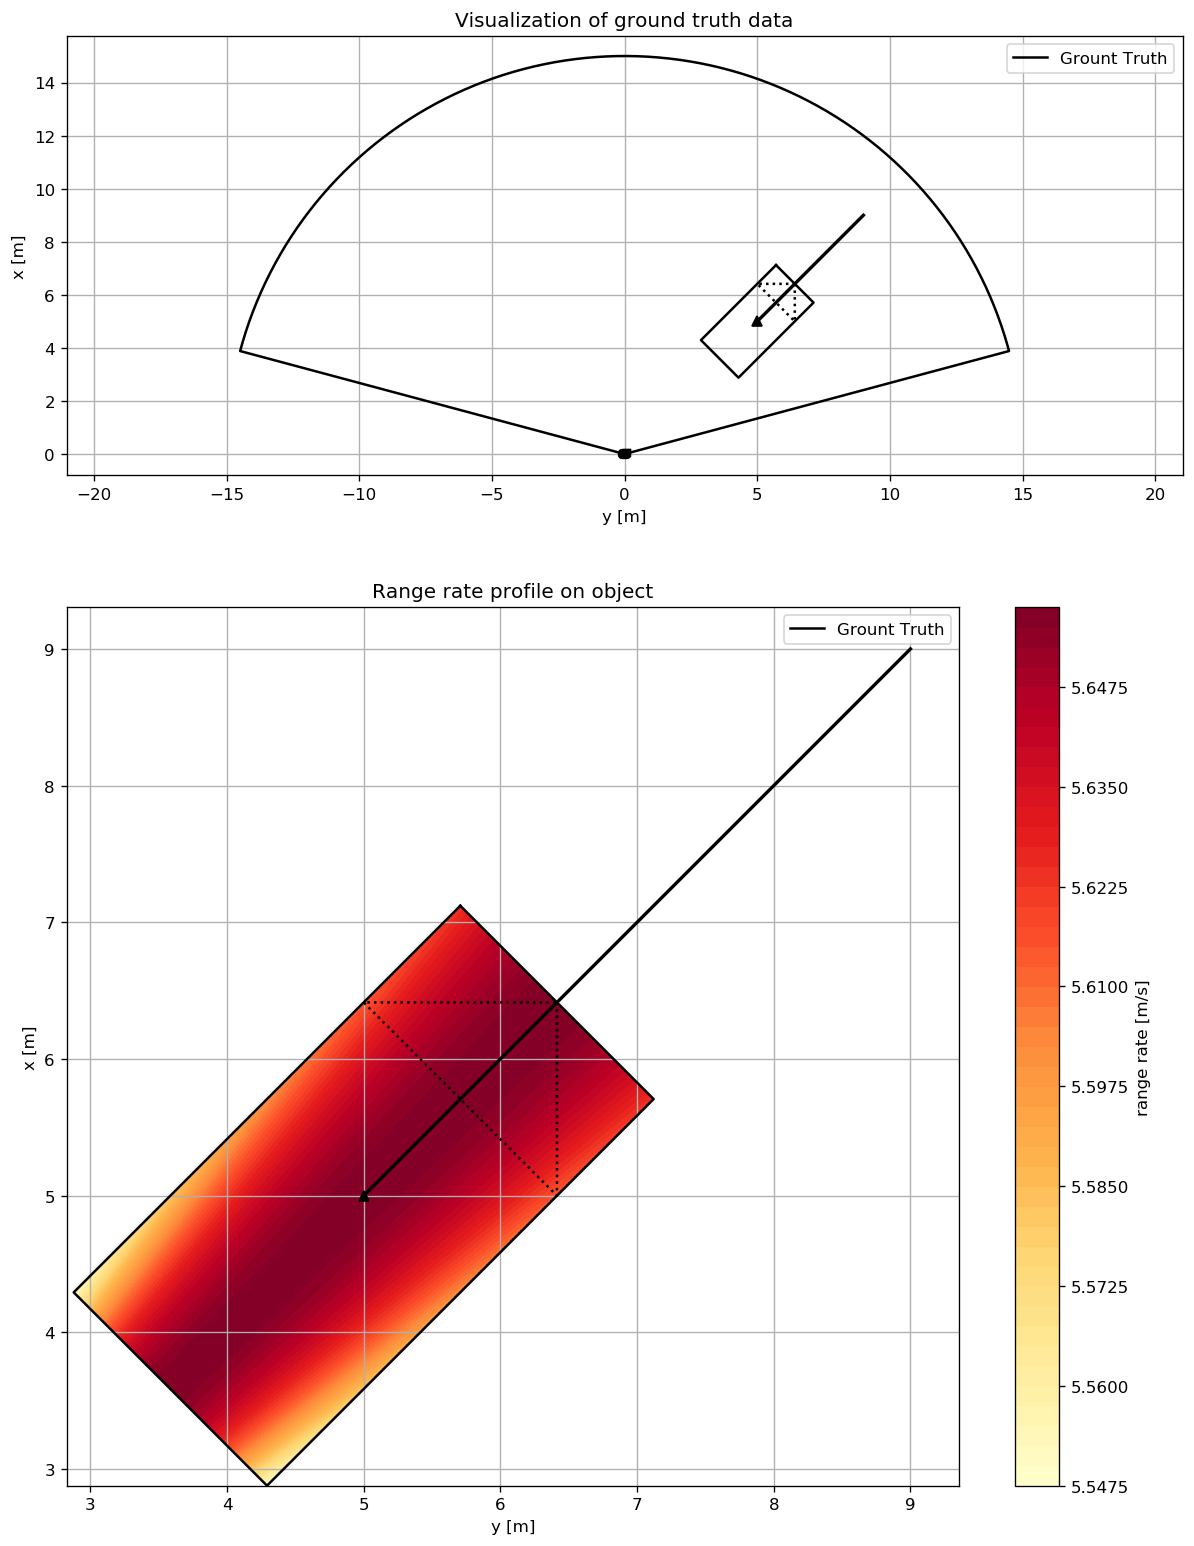

In [35]:
fig1=plt.figure(figsize=(12, 16), dpi= 120, facecolor='w', edgecolor='k')

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2]) 
ax0 = plt.subplot(gs[0])
plot_sensor(ax0, azimuth=np.deg2rad(75.0), max_range=15.0)
plot_object_wrapper(ax0, gt_object, color='k', label='Grount Truth')
ax0.set_title('Visualization of ground truth data')
ax0.set_xlabel('y [m]')
ax0.set_ylabel('x [m]')
ax0.axis('equal')
ax0.grid()
publish_reduced_labels(ax0)

ax1 = plt.subplot(gs[1])
plot_object_wrapper(ax1, gt_object, color='k', label='Grount Truth')
pos_x, pos_y, range_rate = get_range_rate_profile(gt_object)
cont = ax1.contourf(pos_y, pos_x, range_rate, 50, cmap='YlOrRd')
ax1.axis('equal')
ax1.set_xlabel('y [m]')
ax1.set_ylabel('x [m]')
ax1.set_title('Range rate profile on object')
ax1.grid()
cbar = fig1.colorbar(cont, ax=ax1)
cbar.ax.set_ylabel('range rate [m/s]')
publish_reduced_labels(ax1)


In [36]:
ref_pos_std = DefaultReference.pos_std
ref_vel_std = DefaultReference.vel_std

meas_cov = np.power(np.diag([DefaultRadar.range_std, DefaultRadar.azimuth_std, DefaultRadar.range_rate_std]), 2.0)
ref_pos_cov = np.power(np.diag([ref_pos_std, ref_pos_std]), 2.0)
ref_vel_cov = np.power(np.diag([ref_vel_std, ref_vel_std]), 2.0)

object_simulator = RadarObjectSim(gt_object)
det_simulator = DetFromRadarObjectSim(gt_object)

In [37]:
ref_point = [0.0, 0.0]
ref_object = object_simulator.sim(ref_pos_cov, ref_vel_cov)
detection = det_simulator.sim_single_point_from_ref_point(meas_cov, ref_point[0], ref_point[1])


In [38]:
found_point = find_nearest_det_on_object(ref_object, detection)
found_point

ref_point_x                     0
ref_point_y                     0
nees_value                3.17396
opt_success                  True
opt_nit                         1
ref_position_x            4.23153
ref_position_y            3.03271
ref_velocity_rel_x        3.98803
ref_velocity_rel_y        3.98253
deviation_range          0.104815
deviation_azimuth       0.0240873
deviation_range_rate   -0.0315102
dtype: object

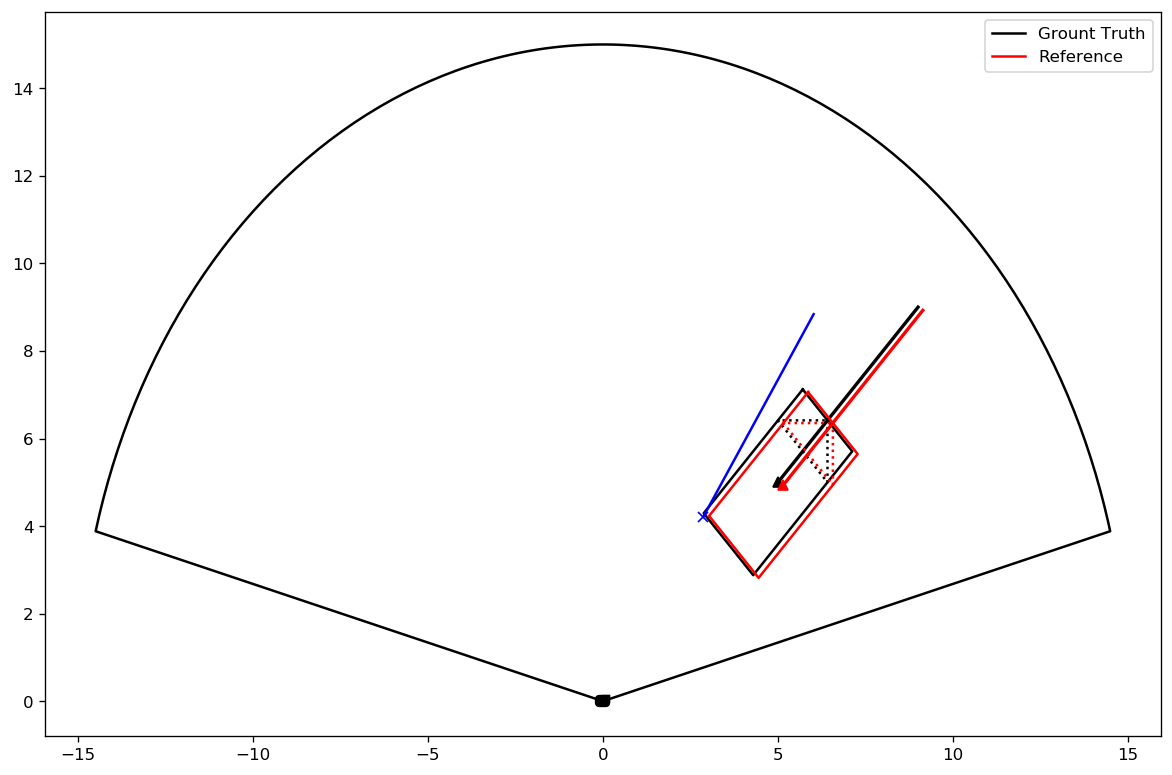

In [39]:
fig1=plt.figure(figsize=(12, 8), dpi= 120, facecolor='w', edgecolor='k')
ax1 = plt.subplot(1, 1, 1)
plot_sensor(ax1, azimuth=np.deg2rad(75.0), max_range=15.0)
plot_object_wrapper(ax1, gt_object, color='k', label='Grount Truth')
plot_object_wrapper(ax1, ref_object, color='r', label='Reference')
plot_detection_wrapper(ax1, detection, color='b')
publish_reduced_labels(ax1)



Text(0.5, 1.0, 'Azimuth-Range Rate NEES profile on object')

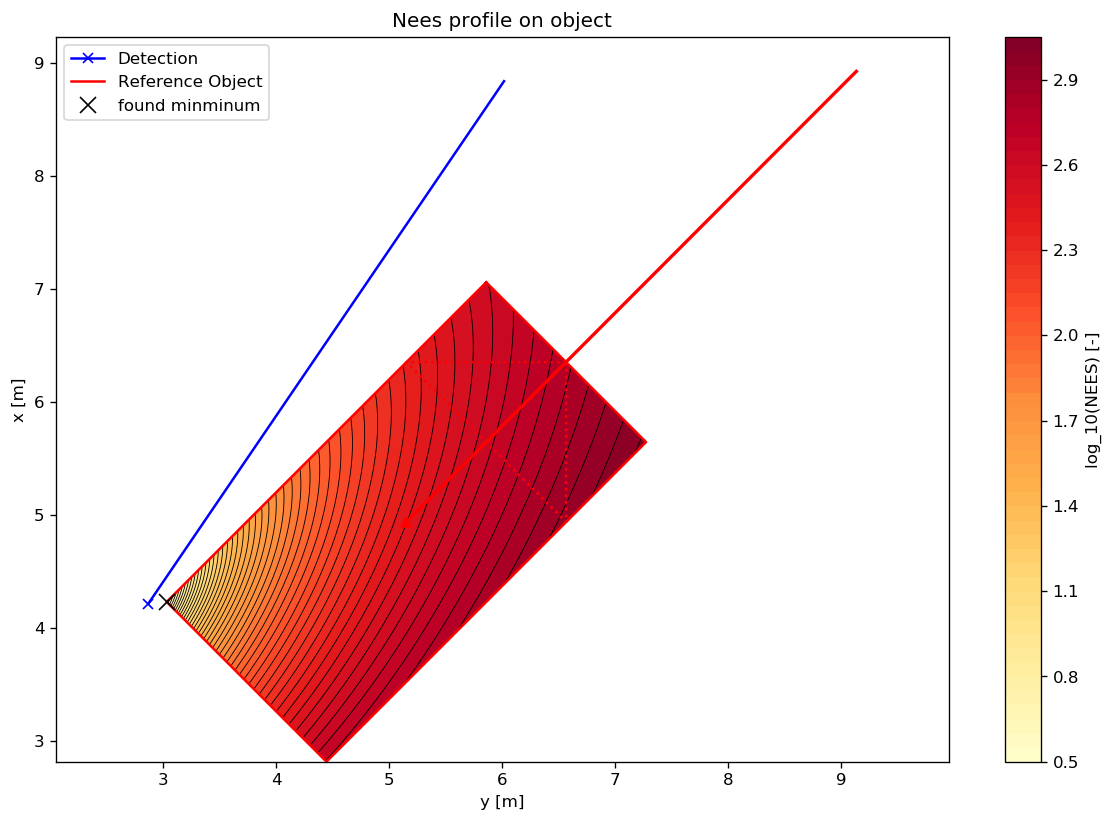

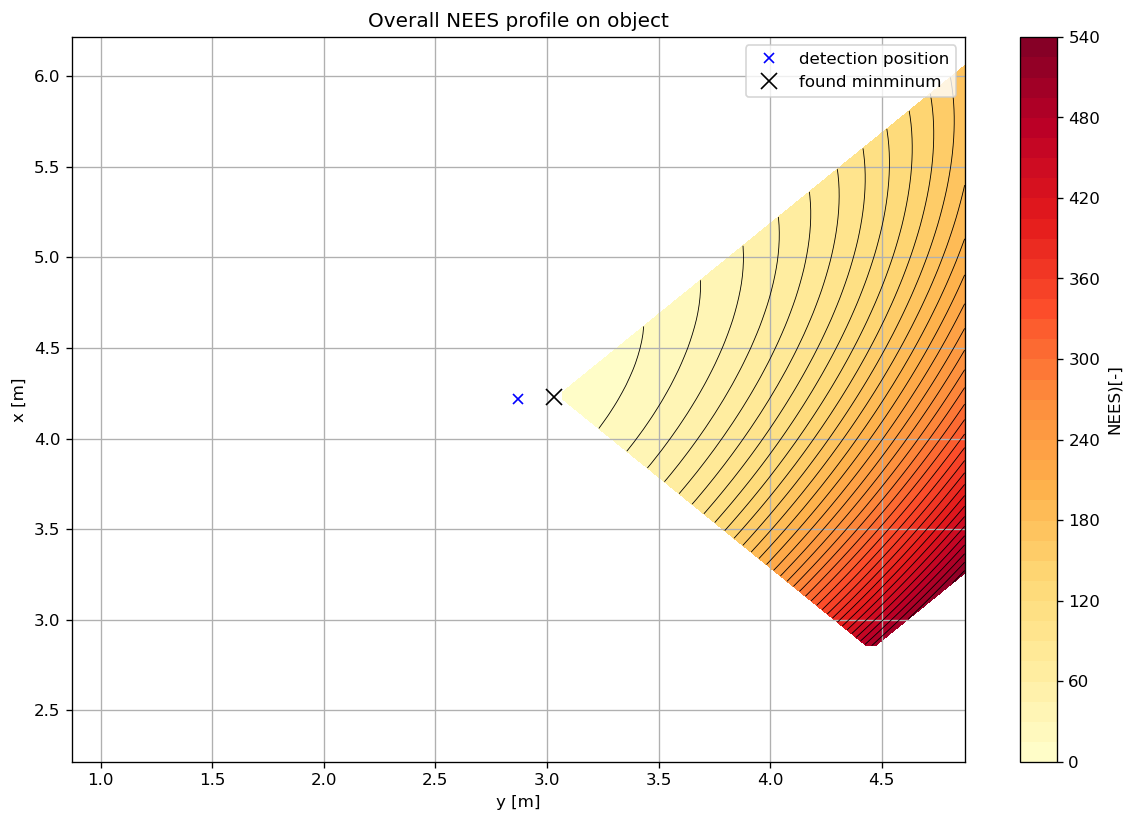

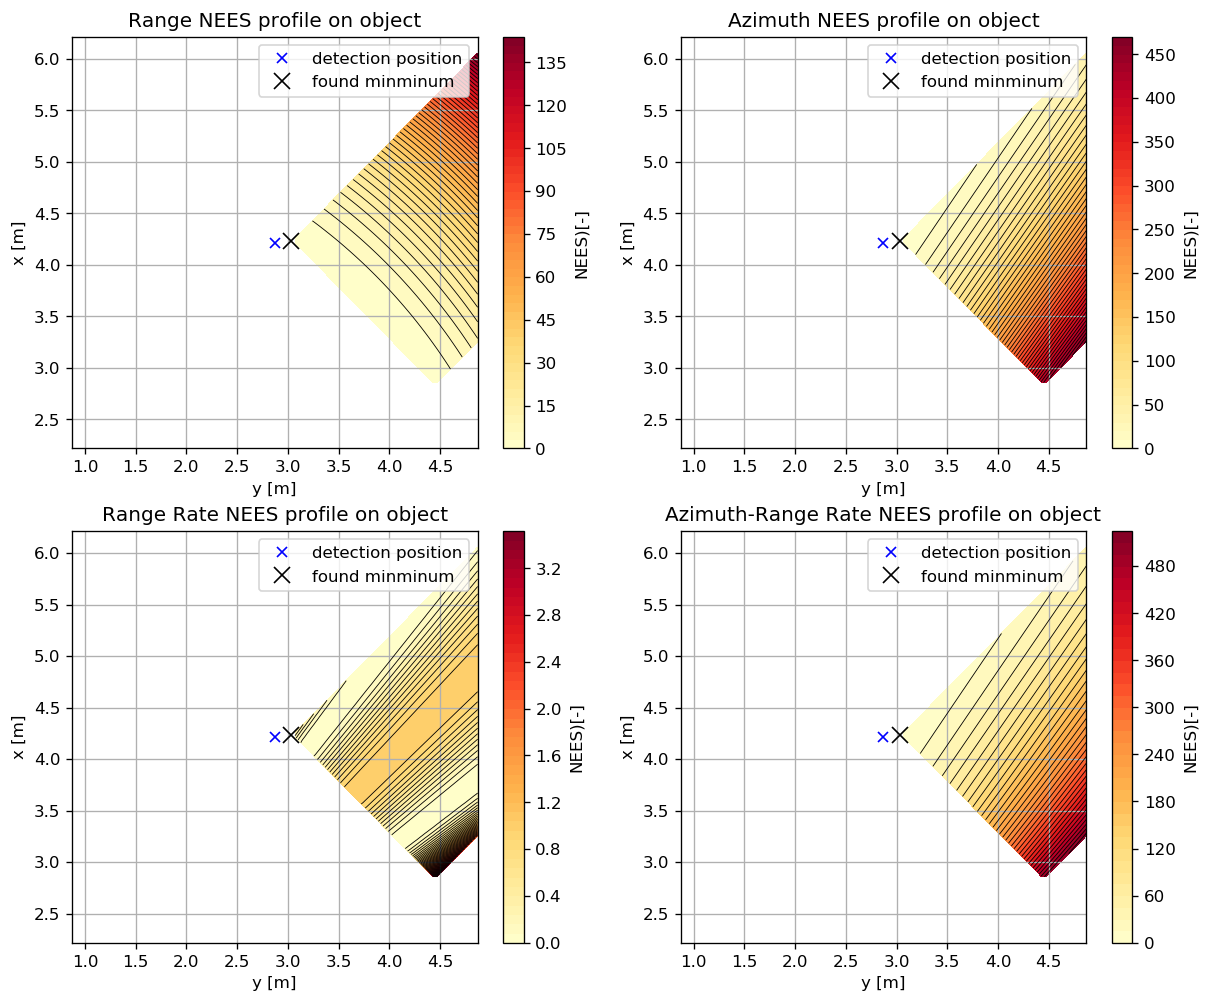

In [40]:
def plot_nees_profile(ax, pos_x, pos_y, nees_value, detection, found_point, n_levels=50):   
    det_x, det_y = pol2cart(detection.det_range, detection.det_azimuth)

    ax.plot(det_y, det_x, 'xb', label='detection position')
    ax.plot(found_point.ref_position_y, found_point.ref_position_x, 'kx', markersize=10, label='found minminum')
    ax.contour(pos_y, pos_x, nees_value, n_levels, colors='k', linewidths=0.5)
    cont = ax.contourf(pos_y, pos_x, nees_value, n_levels, cmap='YlOrRd')
    ax.set_xlabel('y [m]')
    ax.set_ylabel('x [m]')
    
    ax.grid()
    cbar = fig1.colorbar(cont, ax=ax)
    cbar.ax.set_ylabel('NEES)[-]')
    ax.legend()

n_grid = 101
n_levels = 50
pos_x, pos_y, nees = get_nees_profile(ref_object, detection, n_grid)
nees_log10 = np.log10(nees)


fig1=plt.figure(figsize=(12, 8), dpi= 120, facecolor='w', edgecolor='k')

ax1 = plt.subplot(1, 1, 1)
plot_detection_wrapper(ax1, detection, color='b', label='Detection')
plot_object_wrapper(ax1, ref_object, color='r', label='Reference Object')
ax1.plot(found_point.ref_position_y, found_point.ref_position_x, 'kx', markersize=10, label='found minminum')
ax1.contour(pos_y, pos_x, nees_log10, n_levels, colors='k', linewidths=0.5)
cont = ax1.contourf(pos_y, pos_x, nees_log10, n_levels, cmap='YlOrRd')
ax1.axis('equal')
ax1.set_xlabel('y [m]')
ax1.set_ylabel('x [m]')
ax1.set_title('Nees profile on object')
cbar = fig1.colorbar(cont, ax=ax1)
cbar.ax.set_ylabel('log_10(NEES) [-]')
publish_reduced_labels(ax1)

limit = 2.0
det_x, det_y = pol2cart(detection.det_range, detection.det_azimuth)
pos_x, pos_y, nees, nees_r, nees_az, nees_rr, nees_a_rr = get_nees_profile_for_position(ref_object, detection,
                                                                                       det_x-limit, det_x+limit, 
                                                                                       det_y-limit, det_y+limit, n_grid)

fig1=plt.figure(figsize=(12, 8), dpi= 120, facecolor='w', edgecolor='k')
ax0 = plt.subplot(1, 1, 1)
plot_nees_profile(ax0, pos_x, pos_y, nees, detection, found_point, n_levels=n_levels)
ax0.set_title('Overall NEES profile on object')

fig1=plt.figure(figsize=(12, 10), dpi= 120, facecolor='w', edgecolor='k')

ax0 = plt.subplot(2, 2, 1)
plot_nees_profile(ax0, pos_x, pos_y, nees_r, detection, found_point, n_levels=n_levels)
ax0.set_title('Range NEES profile on object')

ax1 = plt.subplot(2, 2, 2)
plot_nees_profile(ax1, pos_x, pos_y, nees_az, detection, found_point, n_levels=n_levels)
ax1.set_title('Azimuth NEES profile on object')

ax2 = plt.subplot(2, 2, 3)
plot_nees_profile(ax2, pos_x, pos_y, nees_rr, detection, found_point, n_levels=n_levels)
ax2.set_title('Range Rate NEES profile on object')

ax3 = plt.subplot(2, 2, 4)
plot_nees_profile(ax3, pos_x, pos_y, nees_a_rr, detection, found_point, n_levels=n_levels)
ax3.set_title('Azimuth-Range Rate NEES profile on object')
